
# UK Band Cultural Impact Analysis

This notebook explores the cultural influence of famous UK bands by city, using real Spotify streaming data.  
By combining each band's follower count with their home city's population, we can estimate **per-capita cultural productivity**.

We'll use the Spotify API to pull artist data, cache it for future runs, and visualize two key metrics:

- **Average listeners per million residents** by city
- **Top band per city** ranked by per-capita impact



In [50]:

import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text



In [8]:
#empty spotify cache
if os.path.exists("spotify_band_data_cache.json"):
    os.remove("spotify_band_data_cache.json")

In [9]:
# Authenticate using credentials from .env
load_dotenv(".env")
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET")
))
CACHE_FILE = "spotify_band_data_cache.json"

In [42]:

# Define bands by city and population
bands_by_city = {
    "Liverpool": ["The Beatles", "Echo & the Bunnymen", "Frankie Goes to Hollywood", "The La's", "The Wombats"],
    "Manchester": ["Oasis", "The Smiths", "New Order", "The Stone Roses", "The 1975"],
    "London": ["The Rolling Stones", "The Clash", "Blur", "Coldplay", "Florence and the Machine"],
    "Birmingham": ["Black Sabbath", "ELO", "Duran Duran", "UB40", "Editors"],
    "Glasgow": ["Simple Minds", "Primal Scream", "Belle and Sebastian", "Franz Ferdinand", "CHVRCHES"],
    "Sheffield": ["Def Leppard", "The Human League", "Pulp", "Arctic Monkeys", "Bring Me The Horizon"],
    "Bristol": ["Massive Attack", "Portishead", "Tricky", "Idles", "Kosheen"]
}
city_pop = {
    "London": 9.65,          # Greater London
    "Birmingham": 2.64,      # West Midlands metro
    "Manchester": 2.87,      # Greater Manchester
    "Glasgow": 1.65,         # Glasgow metro
    "Liverpool": 1.53,       # Liverpool metro
    "Sheffield": 1.57,       # Sheffield urban area
    "Bristol": 0.72          # Bristol urban area
}


In [43]:
bands_by_city = {
    "London": ["The Rolling Stones", "The Clash", "Blur", "Coldplay", "Florence and the Machine"],
    "Birmingham": ["Black Sabbath", "ELO", "Duran Duran", "UB40", "Editors"],
    "Manchester": ["Oasis", "The Smiths", "New Order", "The Stone Roses", "The 1975"],
    "Glasgow": ["Simple Minds", "Primal Scream", "Belle and Sebastian", "Franz Ferdinand", "CHVRCHES"],
    "Liverpool": ["The Beatles", "Echo & the Bunnymen", "Frankie Goes to Hollywood", "The La's", "The Wombats"],
    "Leeds": ["Kaiser Chiefs", "Soft Cell", "Alt-J", "Sisters of Mercy", "The Wedding Present"],
    "Sheffield": ["Def Leppard", "The Human League", "Pulp", "Arctic Monkeys", "Bring Me The Horizon"],
    "Bradford": ["Smokie", "Tasmin Archer", "Kiki Dee", "Ivyrise", "The Cult"],  # The Cult formed nearby
    "Bristol": ["Massive Attack", "Portishead", "Tricky", "Idles", "Kosheen"],
    "Nottingham": ["Jake Bugg", "Dog Is Dead", "London Grammar", "Ten Years After", "Sleaford Mods"]
}

city_pop = {
    "London": 9.65,
    "Birmingham": 2.64,
    "Manchester": 2.87,
    "Glasgow": 1.65,
    "Liverpool": 1.53,
    "Leeds": 1.88,
    "Sheffield": 1.57,
    "Bradford": 1.40,
    "Bristol": 0.72,
    "Nottingham": 1.00
}

In [44]:

# Fetch Spotify data or load from cache
def fetch_from_spotify():
    data = []
    for city, bands in bands_by_city.items():
        for band in bands:
            try:
                result = sp.search(q=f"artist:{band}", type="artist", limit=1)
                artist = result["artists"]["items"][0]
                data.append({
                    "band": band,
                    "city": city,
                    "spotify_id": artist["id"],
                    "monthly_listeners_m": round(artist["followers"]["total"] / 1_000_000, 2),
                    "extracted_at": datetime.now().strftime("%Y-%m-%d")
                })
            except Exception as e:
                print(f"Error fetching {band}: {e}")
    with open(CACHE_FILE, "w") as f:
        json.dump(data, f, indent=2)
    return data

def load_data():
    if Path(CACHE_FILE).exists():
        with open(CACHE_FILE) as f:
            return json.load(f)
    else:
        return fetch_from_spotify()

spotify_data = load_data()
print(len(spotify_data))
print(spotify_data[:3])  # Preview first 3 items


50
[{'band': 'The Rolling Stones', 'city': 'London', 'spotify_id': '22bE4uQ6baNwSHPVcDxLCe', 'monthly_listeners_m': 15.52, 'extracted_at': '2025-08-22'}, {'band': 'The Clash', 'city': 'London', 'spotify_id': '3RGLhK1IP9jnYFH4BRFJBS', 'monthly_listeners_m': 3.11, 'extracted_at': '2025-08-22'}, {'band': 'Blur', 'city': 'London', 'spotify_id': '5OIXzogZi85GrRqWR1Uw9v', 'monthly_listeners_m': 0.0, 'extracted_at': '2025-08-22'}]


In [45]:

# Calculate listeners per million residents
df = pd.DataFrame(spotify_data)
df["ListenersPerMillion"] = df.apply(
    lambda row: row["monthly_listeners_m"] / city_pop[row["city"]], axis=1
)
print(df.shape)
df.head()


(50, 6)


,band,city,spotify_id,monthly_listeners_m,extracted_at,ListenersPerMillion
0,The Rolling Stones,London,22bE4uQ6baNwSHPVcDxLCe,15.52,2025-08-22,1.608290
1,The Clash,London,3RGLhK1IP9jnYFH4BRFJBS,3.11,2025-08-22,0.322280
2,Blur,London,5OIXzogZi85GrRqWR1Uw9v,0.00,2025-08-22,0.000000
3,Coldplay,London,4gzpq5DPGxSnKTe4SA8HAU,59.72,2025-08-22,6.188601
4,Florence and the Machine,London,1moxjboGR7GNWYIMWsRjgG,7.14,2025-08-22,0.739896


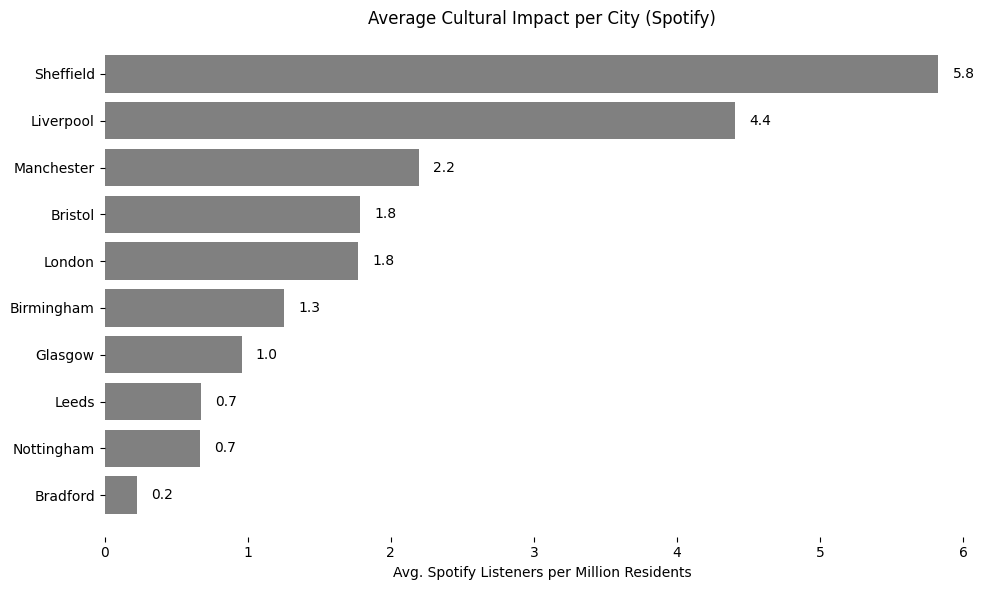

In [57]:
city_avg = df.groupby("city")["ListenersPerMillion"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.barh(city_avg.index, city_avg.values, color="gray", edgecolor="none")

# Remove chart box/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel("Avg. Spotify Listeners per Million Residents")
plt.title("Average Cultural Impact per City (Spotify)")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{width:.1f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

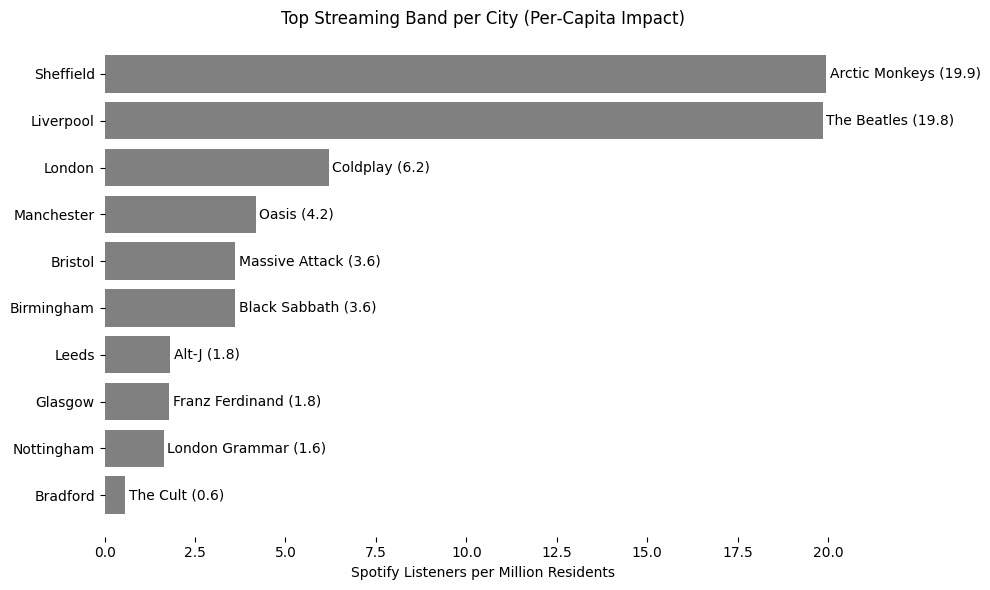

In [56]:
# 🥇 Top band per city by per-capita impact
top_band_per_city = df.sort_values("ListenersPerMillion", ascending=False).groupby("city").first().reset_index()
top_band_per_city = top_band_per_city.sort_values("ListenersPerMillion", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    top_band_per_city["city"],
    top_band_per_city["ListenersPerMillion"],
    color="gray",
    edgecolor="none"
)

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel("Spotify Listeners per Million Residents")
plt.title("Top Streaming Band per City (Per‑Capita Impact)")

for bar, band in zip(bars, top_band_per_city["band"]):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{band} ({width:.1f})", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

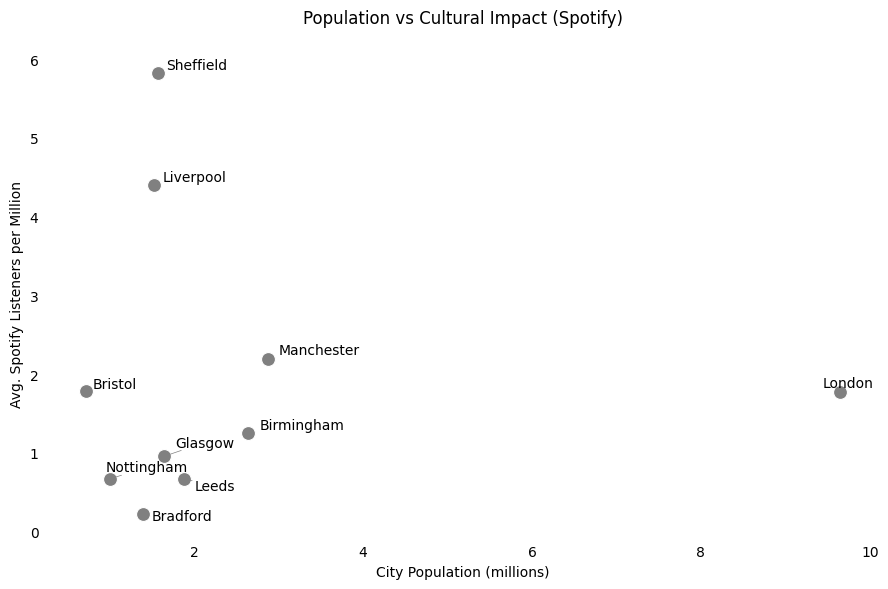

In [51]:
# Prepare data
city_avg = df.groupby("city")["ListenersPerMillion"].mean()
pop_series = pd.Series(city_pop)

scatter_df = pd.DataFrame({
    "City": city_avg.index,
    "Population": pop_series,
    "Impact": city_avg
}).dropna()

# Plot with seaborn
plt.figure(figsize=(9, 6))
sns.scatterplot(data=scatter_df, x="Population", y="Impact", color="gray", s=100)

# Add city labels
texts = []
for _, row in scatter_df.iterrows():
    texts.append(plt.text(row["Population"], row["Impact"], row["City"], fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Minimalist style
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.grid(False)

plt.xlabel("City Population (millions)")
plt.ylabel("Avg. Spotify Listeners per Million")
plt.title("Population vs Cultural Impact (Spotify)", pad=20)

plt.tight_layout()
plt.show()